# Scheduling and Optimisation: Tutor Allocation Problem - Code
* Silvestre Benavente Cartajena
* Isabel Hannebery
* Naryman Tarvand

<i> MAST90050 Scheduling and Optimisation </i>




## Import Libraries

In [58]:
import os
import sys
import copy
import math
import time
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 2023 Semester 2 Schedule

## Initialization
#### Opens data and defines basic parameters

In [59]:
# Opens data
file              = "Data_Scheduling_AN.xlsx"
rootpath          = "./"
sheets            = pd.ExcelFile(os.path.join(rootpath, file))
availability      = pd.read_excel(sheets,'Availability AN',header = 2)
tutor_class       = pd.read_excel(sheets,'Tutor_Class AN')
rooms             = pd.read_excel(sheets,'Rooms AN')
slots             = pd.read_excel(sheets,'Slots AN')
days              = pd.read_excel(sheets,'Days AN')

# Defines quantity of each variable
num_tutors        = len(tutor_class["Tutor ID"].unique())
num_slots         = len(slots)
num_rooms         = len(rooms)
num_days          = len(days)

# Defines what variable corresponds to what index
TUTOR_IDX = 0
SLOT_IDX  = 1
DAY_IDX   = 2
ROOM_IDX  = 3

# Creates decission variable
x = np.zeros((num_tutors, num_slots, num_days, num_rooms))

# Rearranges availability have same index format as decission variable
mon_availability   = np.array(availability[['S01-Mon','S02-Mon','S03-Mon','S04-Mon','S05-Mon']])
tue_availability   = np.array(availability[['S01-Tue','S02-Tue','S03-Tue','S04-Tue','S05-Tue']])
wed_availability   = np.array(availability[['S01-Wed','S02-Wed','S03-Wed','S04-Wed','S05-Wed']])
tutor_availability = np.array([mon_availability,tue_availability,wed_availability])
tutor_availability = np.moveaxis(tutor_availability,0,-1)

print(f'Shape of decission variable x: {np.shape(x)}')
print(f'Shape of tutor availability x: {np.shape(tutor_availability)}')

# Number of times a tutor needs to be scheduled
allocation_num  = np.array(tutor_class['Tutor ID'].value_counts()[availability['Slot']])

# Sets seed
np.random.seed(1000000)

Shape of decission variable x: (21, 5, 3, 6)
Shape of tutor availability x: (21, 5, 3)


## Generation of feasible schedules
#### Randomizes allocation

In [60]:
def generate_random_index(allocation_number, past_indices):
    # Generates an index that hasn't already been considered
    
    index_generated = False

    while not(index_generated):

        # Generates random index
        random_index = np.random.randint(0, allocation_number)

        # If index has not been considered, that index is returned
        # Otherwise repeat process until a feasible index is found
        if random_index not in past_indices:
            index_generated = True

    return random_index

In [61]:
def generate_random_room(rooms, num_rooms):
    # Gets an index of a room that is not occupied
    
    index_generated = False

    # If there are no rooms available, returns -1
    if sum(rooms) == num_rooms:
        return "No Rooms Available"

    # Looks up rooms which are available
    available_rooms = np.where(rooms == 0)

    while not(index_generated):

        # Generates random index
        random_room = np.random.randint(0, num_rooms)

        # If index corresponds to available room, index is returned
        # Otherwise repeat process until a feasible index is found
        if random_room in available_rooms[0]:
            index_generated = True

    return random_room

In [62]:
def generate_feasible_schedule(
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    tutor_availability,
    allocation_num,
    TUTOR_IDX,
):
    # Function generates a feasible schedule

    feasible = False
    attempts = 1

    while not (feasible):

        problem = False

        # Generates decission variable
        x = np.zeros((num_tutors, num_slots, num_days, num_rooms))

        # Iterates over each tutor
        for tutor in range(num_tutors):

            # Gets all slots and days tutor is available
            possible_allocations = np.where(tutor_availability[tutor] == 1)

            # For each tutor, saves indeces of allocated spaces such that tutor is not scheduled to the same time
            past_indeces = []

            # If allocation number greater than possible allocations: problem is infeasable
            if len(possible_allocations[0]) < allocation_num[tutor]:
                print(
                    "Problem is infeasable as number of allocations needed is greater than preference number"
                )
                print("Please review data")
                break

            # Iterates on how many time a tutor needs to be allocated and allocates them to a room
            for i in range(allocation_num[tutor]):

                # Random index (doesn't double schedule the tutor)
                random_index = generate_random_index(
                    len(possible_allocations[0]), past_indeces
                )

                # Gets the slot and day of randomized index
                random_slot = possible_allocations[0][random_index]
                random_day  = possible_allocations[1][random_index]

                # Randomizes room for allocation, and selects a room that is available
                available_rooms = np.apply_over_axes(np.sum, x, TUTOR_IDX)
                available_rooms = available_rooms[0, random_slot, random_day]

                # Gets room that is empty
                random_room = generate_random_room(available_rooms, num_rooms)

                # If can't allocate room: break and restart the porcess
                if random_room == "No Rooms Available":
                    problem = True
                    break

                # Allocates tutor to ranodmized room on randomized slot and day
                x[tutor, random_slot, random_day, random_room] = 1
                past_indeces.append(random_index)

        if problem:
            problem = False
            attempts += 1
        else:
            feasible = True

    return (attempts, x)

## Printing a feasible schedule
#### Given the decission variable $x_{tsdr}$, it produces a schedule

In [63]:
def print_schedule(
    instance,
    slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability,
):
    # Prints out schedule based on the decission variable x

    # Creates empty schedule
    columns = pd.MultiIndex(
        levels=[days["Day"].values, slots["Slot ID"].values],
        codes=[
            [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
            [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        ],
    )
    indeces = rooms["Room ID"].values
    schedule = pd.DataFrame(
        np.zeros((num_rooms, num_days * num_slots)), columns=columns, index=indeces
    )
    schedule = schedule.astype(str)

    # Populates empty schedule with tutors dictated by the decission variable
    for day in range(num_days):
        for room in range(num_rooms):
            for slot in range(num_slots):

                # Finds who is the tutor in that room at that slot at that day
                tutor_index = np.where(instance[:, slot, day, room] == 1)

                # Converts from index form
                day_name = days["Day"][day]
                slot_name = slots["Slot ID"][slot]
                room_name = rooms["Room ID"][room]

                # Populates cell with tutor name, and if no tutor allocated, leaves it empty
                if tutor_index[0].size != 0:
                    # Gets tutor Id
                    tutor_id = availability["Slot"][tutor_index[0]]

                    # Updates schedule
                    schedule.loc[room_name, day_name][slot_name] = tutor_id.values[0]

                else:
                    schedule.loc[room_name, day_name][slot_name] = ""
    return schedule


## Genrating a random feasible schedule

In [64]:
# We generate a random feasible schedule to motivate the problem
attempts, x = generate_feasible_schedule(num_tutors,
    num_slots,
    num_days,
    num_rooms,
    tutor_availability,
    allocation_num,
    TUTOR_IDX)

print(f'Number of attempts needed to create feasible schedule: {attempts}')

schedule = print_schedule(x,
    slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability,
)

schedule


Number of attempts needed to create feasible schedule: 1


Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01                             T17       T12  T18  T04                       
R02         T17                 T10                                           
R03                             T20  T04       T05            T13       T11   
R04         T15                 T04  T07  T05  T02                            
R05    T15                      T16  T21  T21  T06  T02                       
R06    T09                           T16  T06  T13  T08            T01        

               
     S04  S05  
R01  T12       
R02  T19  T19  
R03  T10       
R04  T03       
R05            
R06  T14

# Objective function

## 1) The number of days a tutor has to come into work should be minimized

In [8]:
def total_days_visted_by_tutors(instance):

    # Sums over rooms and slots
    sum_over_rooms_and_slots = np.squeeze(np.sum(instance, axis=(SLOT_IDX, ROOM_IDX)))

    count = 0

    # Iterates over each tutor
    for j in range(num_tutors):

        # Counts the days a tutor has to teach
        count += np.count_nonzero(sum_over_rooms_and_slots[j])

    return count

## 2) The number of rooms used each day should be minimized

In [9]:
def total_rooms_used_in_week(instance):

    # Sums over slots and tutors
    sum_over_tutors_and_slots = np.squeeze(
        np.apply_over_axes(np.sum, instance, [TUTOR_IDX, SLOT_IDX])
    )

    count = 0

    # Iterates over each day
    for j in range(num_days):

        # Counts the rooms that are used each day
        count += np.count_nonzero(sum_over_tutors_and_slots[j])

    return count

## 3) The amount of time a tutor waits in between tutorials should me minimized

In [10]:
def tutors_in_idle(instance):

    # Sums over every room
    sum_over_rooms = np.squeeze(np.apply_over_axes(np.sum, instance, ROOM_IDX))

    idle_time = 0

    # Iterates over each tutor and each day
    for t in range(num_tutors):
        for d in range(num_days):

            # Gets each tutor's schedule for a given day
            day_schedule = sum_over_rooms[t, :, d].astype(int)

            # Looks at the slots which have been assign to
            indeces = np.where(day_schedule == 1)[0]

            # Calculates the time tutor is waiting around in between tutorials
            if len(indeces) > 1:

                idle_time += max(indeces) - min(indeces) + 1 - len(indeces)

    return idle_time

## 4) The amount of times tutors should move rooms in between tutorials should be minimized

In [11]:
def times_tutors_move_rooms_with_b2b_tutorials(instance):

    times_moved = 0

    # Iterates over each tutor over each day
    for t in range(num_tutors):
        for d in range(num_days):

            # Iterates over each slot
            for s in range(num_slots - 1):

                # If that tutor is allocated to that slot in that day
                if sum(instance[t, s, d, :] == 1):

                    # Gets what room it is allocated to
                    room_index = np.where(instance[t, s, d, :] == 1)[0]

                    # Check if tutor is allocated on the next slot
                    if sum(instance[t, s + 1, d, :] == 1):

                        # Gets what room it is allocated to next slot
                        next_room_index = np.where(instance[t, s + 1, d, :] == 1)[0]

                        # Penalizes if rooms are not the same
                        if room_index != next_room_index:
                            times_moved += 1

    return times_moved

### Combining all objectives

In [12]:
def calculate_fitness(individual):

    number_of_visits_cost = total_days_visted_by_tutors(individual)
    rooms_used_cost = total_rooms_used_in_week(individual)
    tutors_waiting_cost = tutors_in_idle(individual)
    moving_rooms_cost = times_tutors_move_rooms_with_b2b_tutorials(individual)

    # print(f'Total number of visits = {number_of_visits_cost}')
    # print(f'Total number of rooms used over the week = {rooms_used_cost}')
    # print(f'Total time tutors spend waiting = {tutors_waiting_cost}')
    # print(f'Total amount of times tutors having to moves rooms = {moving_rooms_cost}')

    return (
        number_of_visits_cost
        + rooms_used_cost
        + tutors_waiting_cost
        + moving_rooms_cost
    )

In [13]:
# Prints out schedule and gets its total cost
schedule = print_schedule(x,
    slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability)

schedule

Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01                             T17       T12  T18  T04                       
R02         T17                 T10                                           
R03                             T20  T04       T05            T13       T11   
R04         T15                 T04  T07  T05  T02                            
R05    T15                      T16  T21  T21  T06  T02                       
R06    T09                           T16  T06  T13  T08            T01        

               
     S04  S05  
R01  T12       
R02  T19  T19  
R03  T10       
R04  T03       
R05            
R06  T14

In [14]:
calculate_fitness(x)

48

## Function to check whether an instance is a feasible solution

In [15]:
def is_feasible_schedule(instance, tutor_availability, allocation_num):

    feasible = True

    # Extends tutor availability by one dimension, to be applied to each room
    A = np.repeat(tutor_availability[:, :, :, np.newaxis], num_rooms, axis=3)

    # Checks instance satisfies tutors availability
    for t in range(num_tutors):
        for s in range(num_slots):
            for d in range(num_days):
                for r in range(num_rooms):

                    if instance[t, s, d, r] > A[t, s, d, r]:
                        feasible = False
                        return feasible

    # Checks tutor is allocated the amount of times it needs to be allocated
    allocated_number = np.squeeze(
        np.apply_over_axes(np.sum, instance, [SLOT_IDX, DAY_IDX, ROOM_IDX])
    )
    for t in range(num_tutors):
        if allocated_number[t] != allocation_num[t]:
            feasible = False
            return feasible

    # Checks that for each room there is at most room tutpr allocated to
    room_usage = np.squeeze(np.apply_over_axes(np.sum, instance, TUTOR_IDX))

    for s in range(num_slots):
        for d in range(num_days):
            for r in range(num_rooms):

                if room_usage[s, d, r] > 1:
                    feasible = False
                    return feasible

    # Checks that a tutor can be at most one room at a time
    tutor_schedule = np.squeeze(np.apply_over_axes(np.sum, instance, ROOM_IDX))

    for t in range(num_tutors):
        for s in range(num_slots):
            for d in range(num_days):

                if tutor_schedule[t, s, d] > 1:
                    feasible = False
                    return feasible

    return feasible

In [16]:
print(f'Is the schedule a feasible solution: {is_feasible_schedule(x,tutor_availability, allocation_num)}')

Is the schedule a feasible solution: True


## Neighbourhood function for GRASP and Tabu Search

In [17]:
def single_swap_neighbourhood(solution, tutor_availability):
    """
    Produce a neighbourhood that contains all feasible swaps from allocations in an existing schedule
    """
    possible_allocations = [
        [slots_idx, day_idx, room_idx]
        for slots_idx in range(num_slots)
        for day_idx in range(num_days)
        for room_idx in range(num_rooms)
    ]
    current_allocations = np.where(solution == 1)

    neighbourhood = []
    for i in range(int(solution.sum())):
        current_tutor = current_allocations[0][i]
        current_slot = current_allocations[1][i]
        current_day = current_allocations[2][i]
        current_room = current_allocations[3][i]
        for allocation in possible_allocations:
            neighbour = solution.copy()
            potential_slot = allocation[0]
            potential_day = allocation[1]
            potential_room = allocation[2]

            # if the tutor is unavailable at that slot and day, continue
            # if any tutor is already in that slot, day and room, continue
            # if the tutor is already in a room at that slot and day, continue
            if (
                (tutor_availability[current_tutor, potential_slot, potential_day] == 0)
                or any(neighbour[current_tutor, potential_slot, potential_day])
                or any(neighbour[:, potential_slot, potential_day, potential_room])
            ):
                continue
            # if there is another tutor in the potential location we want to swap to, and our current tutors position is unavailable, continue
            if any(neighbour[:, potential_slot, potential_day, potential_room]):
                potential_tutor = int(
                    np.where(
                        neighbour[:, potential_slot, potential_day, potential_room]
                    )[0]
                )
                if (
                    tutor_availability[potential_tutor, current_slot, current_day] == 0
                    or any(neighbour[potential_tutor, current_slot, current_day])
                    or any(neighbour[:, current_slot, current_day, current_room])
                ):
                    continue

                neighbour[current_tutor, current_slot, current_day, current_room] = 0
                neighbour[
                    current_tutor, potential_slot, potential_day, potential_room
                ] = 1
                neighbour[
                    potential_tutor, potential_slot, potential_day, potential_room
                ] = 0
                neighbour[potential_tutor, current_slot, current_day, current_room] = 1
            else:
                neighbour[current_tutor, current_slot, current_day, current_room] = 0
                neighbour[
                    current_tutor, potential_slot, potential_day, potential_room
                ] = 1

            neighbourhood.append(neighbour)
    return neighbourhood

# Genetic Algorithm

In [18]:
def get_fitness_scores(population):
    # Function gets the fitness for each indivudal in a population
    
    fitness_scores = np.zeros(POPULATION_NUMBER)

    for i in range(len(population)):
        
        fitness_score = -1*calculate_fitness(population[i])
        
        fitness_scores[i] = fitness_score
        
    return fitness_scores
        

In [19]:
def breed(individual1,individual2):
    # Function breed two parents and produces an offspring
    
    # Initializes child
    child = np.zeros((num_tutors, num_slots, num_days))

     # Relax condition of where tutors are allocated
    parent1 = np.squeeze(np.apply_over_axes(np.sum, individual1, ROOM_IDX))
    parent2 = np.squeeze(np.apply_over_axes(np.sum, individual2, ROOM_IDX))
    
    # Iterates over tutors
    for t in range(num_tutors):

        # Randomly chooses if to take genes from parent one or two
        num = np.random.randint(2)

        if num == 1:
            child[t] = parent1[t]
        else:
            child[t] = parent2[t]
            
    # Extends dimension of child, and assigns rooms sequentially    
    extended_child = np.zeros((num_tutors, num_slots, num_days, num_rooms))

    room_indeces = np.zeros([num_slots,num_days])

    for t in range(num_tutors):
        for s in range(num_slots):
            for d in range(num_days):

                if child[t,s,d] == 1:
                    
                    r = int(room_indeces[s,d])
                    
                    # More than 6 tutors have been allocated to that 
                    if r > num_rooms - 1:
                        return False
                    
                    # Assigns room to that tutor
                    extended_child[t,s,d,r] = 1

                    # Next time someone is allocated to that slot on that time, has to move to the next room
                    room_indeces[s,d] = r + 1
                    
    

    return extended_child    

In [20]:
def generate_child(parent1,parent2):
    # Function generates a feasible offsrping from two parents
    
    feasible_offspring = False
    
    while not(feasible_offspring):
        
        offspring = breed(parent1,parent2)
        
        if type(offspring) == bool:
            continue
            
        
        feasible_offspring = is_feasible_schedule(offspring, tutor_availability, allocation_num)
        
    return offspring

In [21]:
def mutate(individual):
    # Function orders a schedule such that tutors do not move rooms and number of rooms used is minimized
    
    instance = copy.deepcopy(individual) 
    
    for d in range(num_days):
        for s in range(num_slots):
            for r in range(num_rooms):

                # See if a tutor is allofated to this specific room
                t = np.squeeze(np.where(instance[:,s,d,r] == 1))

                if s< 4:

                    # See if that tutor has back to back tutorials
                    next_slot_room = np.squeeze(np.where(instance[t,s+1,d,:] == 1))

                    # If rooms don't match
                    if r!= next_slot_room and next_slot_room in np.arange(num_rooms):

                        t_other = np.squeeze(np.where(instance[:,s+1,d,r] == 1))

                        if t_other in list(np.arange(num_tutors)):
                            instance[t_other,s+1,d,next_slot_room] = 1
                            instance[t_other,s+1,d,r] = 0

                        # Allocates tutor to new room such that b2b tutorials are in the same room
                        instance[t,s+1,d,r] = 1
                        instance[t,s+1,d,next_slot_room] = 0
                        
    return instance

In [22]:
def roulette_wheel_selection(fitness_scores):
    # Function randomly picks two individuals, weighted by the roulette wheel strategy
    
    pick_num  = 2
    prob_dist = np.exp(fitness_scores)/sum(np.exp(fitness_scores))
    indeces   = np.arange(len(fitness_scores))
    
    picks     = np.random.choice(indeces,pick_num,p=prob_dist,replace = False)
    
    return picks

In [23]:
# Silences deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Measures run-time of algorithm
start_time = time.time()

# Initializes population
POPULATION_NUMBER = 200
population        = []

for i in range(POPULATION_NUMBER):
    _ , x = generate_feasible_schedule(num_tutors,
    num_slots,
    num_days,
    num_rooms,
    tutor_availability,
    allocation_num,
    TUTOR_IDX)
    population.append(x)
    
# Iterates over generations
MAX_GENERATIONS    = 100

# Saves score over iterations
iterations = []
scores     = []

for generation in range(MAX_GENERATIONS):
    
    # Defines the next generation
    next_generation = np.zeros((POPULATION_NUMBER,num_tutors, num_slots, num_days, num_rooms))
    
    # Calculates the fitness score for each individual in the population
    fitness_scores = get_fitness_scores(population)
    
    #print(max(fitness_scores))
    
    # Gets indeces of two highest scoring individuals
    top_indeces      = np.flip(np.argpartition(fitness_scores, -2)[-2:])
    top_index        = top_indeces[0]
    second_top_index = top_indeces[1]
    
    # By elitism, individuals are selected to go onto the next generation
    next_generation[0] = population[top_index]
    next_generation[1] = population[second_top_index]
    
    for i in range(2,POPULATION_NUMBER-10):
        
        # Chooses two parents based on roulette wheel strategy
        parents_indeces = roulette_wheel_selection(fitness_scores)
        parent1         = population[parents_indeces[0]]
        parent2         = population[parents_indeces[1]]
        
        # Creates a feasible offspring from the two parents
        offspring         = generate_child(parent1,parent2)
        mutated_offspring = mutate(offspring)
        
        # Appends child to next generation
        next_generation[i] = mutated_offspring
     
    # Insert new indivudals at each generation
    for i in range(POPULATION_NUMBER-10,POPULATION_NUMBER):
        _ , x = generate_feasible_schedule(num_tutors,
    num_slots,
    num_days,
    num_rooms,
    tutor_availability,
    allocation_num,
    TUTOR_IDX)
        
        # Appends child to next generation
        next_generation[i] = x
    # Updates new generation    
    population = next_generation  
    
    # Saves max score and iteration number
    iterations.append(generation)
    scores.append(max(fitness_scores))
    
# End time of algorithm
end_time = time.time()

## Genetic Algorithm Schedule

In [24]:
# Prints out the best schedule from Genetic Algorithm
schedule   = print_schedule(population[top_index], slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability)
best_score = calculate_fitness(population[top_index])

schedule

Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01    T09                      T05  T05  T06  T06  T20       T13  T13  T11   
R02    T17  T17                 T14  T07  T12  T12  T08            T10  T10   
R03    T15  T15                 T18  T21  T21  T02  T02                       
R04                             T16  T16  T04  T04  T04                       
R05                                                                           
R06                                                                           

               
     S04  S05  
R01  T01  T03  
R02  T19  T19  
R03            
R04            
R05            
R06

In [25]:
# Prints out cost and run time
print('Total Cost of Best Solution:', best_score)
print('Genetic Algorithm Run-Time:',  round(end_time - start_time,3), 'seconds')

Total Cost of Best Solution: 30
Genetic Algorithm Run-Time: 43.496 seconds


# Tabu Search

In [26]:
def tabu_search(tabu_list_size, iter_without_improv, neighb_subset_size):
    # Generate starting solution
    _, current_solution = generate_feasible_schedule(num_tutors,
    num_slots,
    num_days,
    num_rooms,
    tutor_availability,
    allocation_num,
    TUTOR_IDX)
    # our first values
    best_solution = current_solution
    best_solution_value = calculate_fitness(current_solution)
    #print(f"Initial sol has value {best_solution_value}")
    tabu_list = [current_solution]
    term_counter = 0

    i = 0
    iterations = []
    best_solutions = []
    while term_counter < iter_without_improv:
        # create neighbourhood
        neighbourhood = single_swap_neighbourhood(current_solution, tutor_availability)
        # picking a random subset of 100
        neighbourhood = random.sample(neighbourhood, neighb_subset_size)
        # initialising best neighbour

        neighbour_vals = []
        for neighbour in neighbourhood:
            # go thru neighbourhood and calculate the fitness of each neighbour
            neighbour_vals += [(neighbour, calculate_fitness(neighbour))]
        while True:
            # Find the index of the tuple with the lowest second element (x[1])
            index_min_obj = min(range(len(neighbour_vals)), key=lambda i: neighbour_vals[i][1])

            # Use the index to access the actual values
            best_neighbour_pair = neighbour_vals[index_min_obj]
            best_neighbour = best_neighbour_pair[0]
            best_neighbour_val = best_neighbour_pair[1]

            is_in_tabu_list = any(np.array_equal(neighbour, arr) for arr in tabu_list)
            if not is_in_tabu_list:
                current_solution = best_neighbour
                current_obj = best_neighbour_val
                tabu_list.append(best_neighbour)
                if best_neighbour_val < best_solution_value:
                    # best neighbour is better than our best sol, update
                    best_solution = current_solution
                    best_solution_value = current_obj
                    # we've got an improvement
                    term_counter = 0
                else:
                    # no improvement
                    term_counter += 1
                break
            else:
                # We are in the tabu list
                if best_neighbour_val <= best_solution_value:
                    current_solution = best_neighbour
                    current_obj = best_neighbour_val
                    best_solution = current_solution
                    best_solution_value = current_obj
                    #print("Aspiration criteria met, revoked from tabu list")
                    if best_neighbour_val < best_solution_value:
                        # improvement made
                        term_counter = 0
                    if best_neighbour_val == best_solution_value:
                        # no improvement made
                        term_counter += 1
                    break
                else:
                    # We are in tabu, and our best sol is not better
                    updated_pair = (best_neighbour, math.inf)
                    neighbour_vals[index_min_obj] = updated_pair
                    #print("Best sol was in tabu list, but aspiration criteria not met")
                    term_counter += 1
                    continue

        if len(tabu_list) > tabu_list_size:
            # remove from tabu list once it gets too big
            tabu_list.pop(0)
        i += 1

        iterations += [i]
        best_solutions += [best_solution_value]
        #print(f"Iteration {i}, Best Value: {best_solution_value}")

    return iterations, best_solutions, best_solution, best_solution_value

In [27]:
# Code to run Tabu Search, along with average time taken, amount of iterations, and the best sol out of a number of runs
tabu_attempts = []
times = []
num_tabu_runs = 10
for i in range(num_tabu_runs):
    #print(f"Tabu run {i}")
    start_time = time.time()
    tabu_iterations, tabu_best_sols, sol, sol_value = tabu_search(tabu_list_size=500, iter_without_improv=100, neighb_subset_size=100)
    times += [float(time.time() - start_time)]
    tabu_attempts += [(tabu_iterations, tabu_best_sols, sol, sol_value)]

best_pair       = min(tabu_attempts, key=lambda x: x[3])
tabu_iterations = best_pair[0]
tabu_best_sols  = best_pair[1]
best_sol        = best_pair[2]
best_val        = best_pair[3]




## Tabu Search Schedule

In [28]:
# Prints out the best schedule from Tabu Search
schedule = print_schedule(best_sol, slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability)

schedule

Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01    T15                      T05  T05  T06  T16  T16                       
R02    T17  T17                 T20  T14  T21                                 
R03                                  T21  T18  T06            T13  T13  T01   
R04                             T04  T04  T04  T02  T02       T10  T10  T19   
R05    T09  T15                      T07  T12  T12  T08                       
R06                                                                           

               
     S04  S05  
R01            
R02            
R03  T03  T11  
R04  T19       
R05            
R06

In [29]:
print('Total Cost of Best Solution:', best_val)
print('TABU Search Average Run-Time:',  round(np.mean(times),3), 'seconds')

Total Cost of Best Solution: 34
TABU Search Average Run-Time: 12.558 seconds


# Grasp

In [30]:
def greedy_randomised_construction(availability, tutor_class, tutor_availability):
    """
    Produce a greedy randomised construction of a schedule.
    First randomly shuffle the list of all possible allocations (slot, day, room) and the list of tutors.
    For all possible allocations iterate over the tutors and if it's feasible,
    assign the tutor that has the lowest marginal cost to that position.
    """
    # start with an empty solution
    schedule = np.zeros((num_tutors, num_slots, num_days, num_rooms))

    # define and shuffle all possible locations
    possible_allocations = [
        [slots_idx, day_idx, room_idx]
        for slots_idx in range(num_slots)
        for day_idx in range(num_days)
        for room_idx in range(num_rooms)
    ]
    random.shuffle(possible_allocations)

    # define and shuffle all tutors
    tutor_to_idx = dict(zip(availability["Slot"], availability.index))
    unassigned_tutors = tutor_class["Tutor ID"].to_list()
    random.shuffle(unassigned_tutors)

    unassigned_tutor_idx = [tutor_to_idx[tutor] for tutor in unassigned_tutors]

    for allocation in possible_allocations:
        cost = []
        valid_tutors = []

        # if no more tutors to assign, stop
        if len(unassigned_tutor_idx) == 0:
            break

        for tutor in unassigned_tutor_idx:
            # if the tutor is unavailable at that slot and day, continue
            # if any tutor is already in that slot, day and room, continue
            # if the tutor is already in a room at that slot and day, continue
            if (
                (tutor_availability[tutor, allocation[0], allocation[1]] == 0)
                or any(schedule[:, allocation[0], allocation[1], allocation[2]])
                or any(schedule[tutor, allocation[0], allocation[1], :])
            ):
                continue
            schedule_copy = schedule.copy()
            schedule_copy[tutor, allocation[0], allocation[1], allocation[2]] = 1
            cost.append(calculate_fitness(schedule_copy))
            valid_tutors.append(tutor)
        if len(cost) == 0:
            continue

        # allocate the lowest cost tutor to that slot, day and room
        lowest_cost_tutor = valid_tutors[cost.index(min(cost))]
        schedule[lowest_cost_tutor, allocation[0], allocation[1], allocation[2]] = 1
        unassigned_tutor_idx.pop(unassigned_tutor_idx.index(lowest_cost_tutor))

    return schedule

In [31]:
def select_neighbour(neighbourhood):
    """
    Choose the lowest cost neighbour in the neighbourhood
    """

    costs = []
    for neighbour in neighbourhood:
        costs.append(calculate_fitness(neighbour))

    candidate_solution = neighbourhood[np.argmin(costs)]
    cost = np.min(costs)

    return candidate_solution, cost

In [32]:
def local_search(solution, tutor_availability):
    """
    Produce a local search schedule. Find the best neighbour in the neighbourhood of the current solution.
    If the best neighbour is no better than the current solution, return the current solution.
    Otherwise repeat.
    """
    cost = calculate_fitness(solution)

    while True:
        neighbourhood = single_swap_neighbourhood(solution, tutor_availability)
        candidate_solution, candidate_cost = select_neighbour(neighbourhood)

        if candidate_cost < cost:
            cost = candidate_cost
            solution = candidate_solution
        else:
            break

    return solution, cost

In [33]:
def grasp_algorithm(n_iterations, availability, tutor_class, tutor_availability):
    """
    Run the GRASP algorithm. This involves,
    iteratively finding a greedy solution and perform a random search.
    """
    cost = np.inf
    for i in range(n_iterations):
        #print(f"iteration {i}")
        # start randomised greedy construction
        greedy_random_solution = greedy_randomised_construction(
            availability, tutor_class, tutor_availability
        )

        # start local search
        local_search_solution, local_search_cost = local_search(
            greedy_random_solution, tutor_availability
        )

        if local_search_cost < cost:
            cost = local_search_cost
            solution = local_search_solution
            #print(f"Optimal value of {cost}")

    return solution, cost

In [34]:
n_iterations = 60
t0 = time.time()

solution, cost = grasp_algorithm(
    n_iterations, availability, tutor_class, tutor_availability
)

solution = greedy_randomised_construction(availability, tutor_class, tutor_availability)

tf       = time.time()


## GRASP Schedule

In [35]:
# Prints out the best schedule from GRASP
schedule = print_schedule(solution, slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability)

schedule

Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01         T15                 T18  T07       T16            T13             
R02                                  T05  T06       T02            T12        
R03    T09                      T04  T21  T16                 T10       T08   
R04    T15                      T20            T05  T04            T13  T19   
R05                                            T02                            
R06    T17  T17                      T04  T21  T06                 T10        

               
     S04  S05  
R01  T14  T01  
R02       T11  
R03            
R04       T03  
R05            
R06  T12  T19

In [36]:
print('Total Cost of Best Solution:', cost)
print('GRASP Run-Time:',  round(tf - t0,3), 'seconds')

Total Cost of Best Solution: 34
GRASP Run-Time: 104.058 seconds


# 2) Case Study: Expansion Plan

## Initialization
#### Opens data and defines basic parameters

In [37]:
# Opens data
file              = "Data_Scheduling_AN_New_Instance.xlsx"
rootpath          = "./"
sheets            = pd.ExcelFile(os.path.join(rootpath, file))
availability      = pd.read_excel(sheets,'Availability AN',header = 2)
tutor_class       = pd.read_excel(sheets,'Tutor_Class AN')
rooms             = pd.read_excel(sheets,'Rooms AN')
slots             = pd.read_excel(sheets,'Slots AN')
days              = pd.read_excel(sheets,'Days AN')

# Defines quantity of each variable
num_tutors        = len(tutor_class["Tutor ID"].unique())
num_slots         = len(slots)
num_rooms         = len(rooms)
num_days          = len(days)

# Defines what variable corresponds to what index
TUTOR_IDX = 0
SLOT_IDX = 1
DAY_IDX = 2
ROOM_IDX = 3

# Creates decission variable
x = np.zeros((num_tutors, num_slots, num_days, num_rooms))

# Rearranges availability have same index format as decission variable
mon_availability   = np.array(availability[['S01-Mon','S02-Mon','S03-Mon','S04-Mon','S05-Mon']])
tue_availability   = np.array(availability[['S01-Tue','S02-Tue','S03-Tue','S04-Tue','S05-Tue']])
wed_availability   = np.array(availability[['S01-Wed','S02-Wed','S03-Wed','S04-Wed','S05-Wed']])
tutor_availability = np.array([mon_availability,tue_availability,wed_availability])
tutor_availability = np.moveaxis(tutor_availability,0,-1)

print(f'Shape of decission variable x: {np.shape(x)}')
print(f'Shape of tutor availability x: {np.shape(tutor_availability)}')

# Number of times a tutor needs to be scheduled
allocation_num  = np.array(tutor_class['Tutor ID'].value_counts()[availability['Slot']])

Shape of decission variable x: (40, 5, 3, 8)
Shape of tutor availability x: (40, 5, 3)


# Genetic Algorithm

In [38]:
# Sets seed
np.random.seed(1000000)

# Silences deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Measures run-time of algorithm
start_time = time.time()

# Initializes population
POPULATION_NUMBER = 200
population = []

for i in range(POPULATION_NUMBER):
    _ , x = generate_feasible_schedule(num_tutors,
    num_slots,
    num_days,
    num_rooms,
    tutor_availability,
    allocation_num,
    TUTOR_IDX)
    population.append(x)
    
# Iterates over generations
MAX_GENERATIONS    = 100

# Saves score over iterations
iterations = []
scores     = []

for generation in range(MAX_GENERATIONS):
    
    next_generation = np.zeros((POPULATION_NUMBER,num_tutors, num_slots, num_days, num_rooms))
    
    # Calculates the fitness score for each individual in the population
    fitness_scores = get_fitness_scores(population)
    
    #print(max(fitness_scores))
    
    # Gets indeces of two highest scoring individuals
    top_indeces      = np.flip(np.argpartition(fitness_scores, -2)[-2:])
    top_index        = top_indeces[0]
    second_top_index = top_indeces[1]
    
    # By elitism, individuals are selected to go onto the next generation
    next_generation[0] = population[top_index]
    next_generation[1] = population[second_top_index]
    
    for i in range(2,POPULATION_NUMBER-10):
        
        parents_indeces = roulette_wheel_selection(fitness_scores)
        parent1         = population[parents_indeces[0]]
        parent2         = population[parents_indeces[1]]
        
        # Creates a feasible offspring from the two parents
        offspring         = generate_child(parent1,parent2)
        mutated_offspring = mutate(offspring)
        
        # Appends child to next generation
        next_generation[i] = mutated_offspring
        
    for i in range(POPULATION_NUMBER-10,POPULATION_NUMBER):
        _ , x = generate_feasible_schedule(num_tutors,
    num_slots,
    num_days,
    num_rooms,
    tutor_availability,
    allocation_num,
    TUTOR_IDX)
        
        # Appends child to next generation
        next_generation[i] = x
        
    population = next_generation  
    
    iterations.append(generation)
    scores.append(max(fitness_scores))
    
# End time of algorithm
end_time = time.time()

## Genetic Algorithm Schedule

In [39]:
# Prints out the best schedule from Genetic Algorithm
schedule   = print_schedule(population[top_index], slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability)

best_score = calculate_fitness(population[top_index])
schedule

Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01    T17  T17                 T05  T05  T01  T20  T08       T23  T07  T29   
R02    T15  T15                 T14  T21  T21  T02  T02       T26  T12  T12   
R03    T40  T09                 T10  T10  T06  T06  T27       T28  T31  T31   
R04                             T16  T16  T13  T13  T24       T38  T38  T39   
R05                             T30  T18  T04  T04  T04                       
R06                             T33  T29  T29  T37  T37                       
R07                             T35  T32  T22  T22  T36                       
R08                                                                           

               
     S04  S05  
R01  T19  T19  
R02  T11  T03  
R03  T25  T25  
R04  T34  T34  
R05            
R06            
R07            
R08

In [40]:
print('Total Cost of Best Solution:', best_score)
print('Genetic Algorithm Run-Time:',  round(end_time - start_time,3), 'seconds')

Total Cost of Best Solution: 55
Genetic Algorithm Run-Time: 81.681 seconds


## Tabu Search

In [41]:
# Code to run Tabu Search, along with average time taken, amount of iterations, and the best sol out of a number of runs
tabu_attempts = []
times = []
num_tabu_runs = 10
for i in range(num_tabu_runs):
    #print(f"Tabu run {i}")
    start_time = time.time()
    tabu_iterations, tabu_best_sols, sol, sol_value = tabu_search(tabu_list_size=500, iter_without_improv=100, neighb_subset_size=100)
    times += [float(time.time() - start_time)]
    tabu_attempts += [(tabu_iterations, tabu_best_sols, sol, sol_value)]
best_pair = min(tabu_attempts, key=lambda x: x[3])
tabu_iterations = best_pair[0]
tabu_best_sols = best_pair[1]
best_sol = best_pair[2]
best_val = best_pair[3]



## Tabu Search Schedule

In [42]:
# Prints out the best schedule from Tabu Search
schedule = print_schedule(best_sol, slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability)

schedule

Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01                             T32  T20  T01  T04  T36            T38  T38   
R02                             T18  T21  T16  T16            T30  T07  T12   
R03    T15  T39                 T04  T04  T06  T06                 T28        
R04                             T10  T10  T27  T22  T22            T29  T29   
R05    T09  T15                 T40  T13  T13  T02  T08                       
R06                                  T35  T21  T14  T02            T26  T11   
R07                             T23  T24  T33  T37  T37                       
R08    T17  T17                 T05  T05  T34  T34                            

               
     S04  S05  
R01  T25  T25  
R02  T12  T03  
R03  T31  T31  
R04  T29       
R05            
R06  T19  T19  
R07            
R08

In [43]:
print('Total Cost of Best Solution:', best_val)
print('TABU Search Average Run-Time:',  round(np.mean(times),3), 'seconds')

Total Cost of Best Solution: 60
TABU Search Average Run-Time: 36.928 seconds


## GRASP

In [44]:
n_iterations = 60
t0 = time.time()

solution, cost = grasp_algorithm(
    n_iterations, availability, tutor_class, tutor_availability
)
solution = greedy_randomised_construction(availability, tutor_class, tutor_availability)

tf = time.time()

## GRASP Schedule

In [45]:
schedule = print_schedule(solution, slots,
    days,
    rooms,
    num_tutors,
    num_slots,
    num_days,
    num_rooms,
    availability)

schedule

Monday                  Tuesday                     Wednesday            \
       S01  S02 S03 S04 S05     S01  S02  S03  S04  S05       S01  S02  S03   
R01    T25  T25                 T35  T21       T18                            
R02    T17  T09                 T05       T12  T02  T02       T28       T34   
R03    T15  T22                      T33  T21       T13       T23  T34  T11   
R04    T13  T40                 T20  T05  T04  T08            T39  T31  T31   
R05                             T17  T24  T16  T16  T29                       
R06    T38  T26                           T06  T06            T10  T10  T03   
R07    T22  T30                 T04       T27       T37       T32  T07        
R08    T29  T15                      T04       T36            T29             

               
     S04  S05  
R01  T12  T37  
R02  T01       
R03  T19  T19  
R04            
R05       T38  
R06            
R07  T14       
R08

In [46]:
# Prints out the best schedule from GRASP
print('Total Cost of Best Solution:', cost)
print('GRASP Run-Time:',  round(tf - t0,3), 'seconds')

Total Cost of Best Solution: 61
GRASP Run-Time: 738.931 seconds


## Cost over iterations for each algorithm using both instances

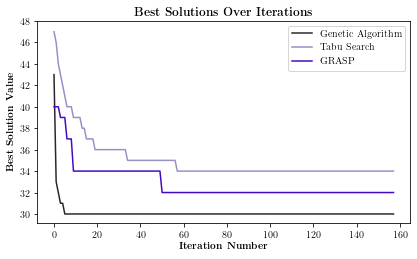

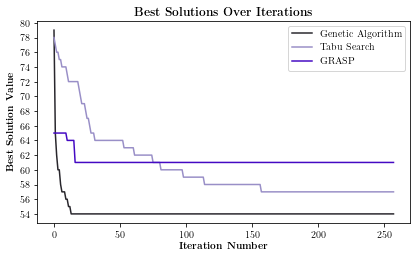

In [47]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

# INSTANCE 1
ga_iterations_i1 = list(range(1, 101))
ga_best_sols_i1  = [43, 33, 32, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
                    30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
                    30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
                    30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


tabu_iterations_i1 = list(range(1,159))
tabu_best_sols_i1  = [47, 46, 44, 43, 42, 41, 40, 40, 40, 39, 39, 39, 39, 38, 38, 37, 37, 37, 37, 36, 36, 36, 36, 
                      36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 
                      35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 
                      34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 
                      34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 
                      34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 
                      34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,34, 34, 34, 34, 34, 34, 34, 34]


grasp_iterations_i1 = list(range(60))
grasp_best_sols_i1  = [40, 40, 40, 39, 39, 39, 37, 37, 37, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
                       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
                       34, 34, 34, 34, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]


# Combiness all iterations and all scores into one
all_iters_i1     = [ga_iterations_i1, tabu_iterations_i1, grasp_iterations_i1]
all_best_sols_i1 = [ga_best_sols_i1, tabu_best_sols_i1, grasp_best_sols_i1]


# INSTANCE 2
ga_iterations_i2 = list(range(1, 101))
ga_best_sols_i2  = [79.0, 65.0, 62.0, 60.0, 60.0, 58.0, 57.0, 57.0, 57.0, 56.0, 56.0, 55.0, 55.0, 54.0, 54.0, 
                    54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 
                    54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 
                    54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 
                    54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 
                    54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 
                    54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0]


tabu_iterations_i2 = list(range(1, 259))
tabu_best_sols_i2  = [78, 77, 76, 76, 75, 75, 74, 74, 74, 74, 73, 72, 72, 72, 72, 72, 72, 72, 72, 71, 70, 69, 69, 
                      69, 68, 67, 67, 66, 65, 65, 65, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 
                      64, 64, 64, 64, 64, 64, 64, 63, 63, 63, 63, 63, 63, 63, 63, 62, 62, 62, 62, 62, 62, 62, 62, 
                      62, 62, 62, 62, 62, 62, 61, 61, 61, 61, 61, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 
                      60, 60, 60, 60, 60, 60, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 58, 
                      58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 
                      58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 57, 57, 57, 57, 
                      57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 
                      57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 
                      57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 
                      57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 
                      57, 57, 57, 57, 57]


grasp_iterations_i2 = list(range(60))
grasp_best_sols_i2  = [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64, 61, 61, 61, 61, 61, 61, 61,
                       61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
                       61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61]

# Combiness all iterations and all scores into one
all_iters_i2     = [ga_iterations_i2, tabu_iterations_i2, grasp_iterations_i2]
all_best_sols_i2 = [ga_best_sols_i2, tabu_best_sols_i2, grasp_best_sols_i2]


def ensure_max_length(lst, max_length):
    if len(lst) < max_length:
        lst.extend([lst[-1]] * (max_length - len(lst)))

def create_graph(iterations, best_sols, instance):
    # Intakes a list of iterations lists and a list of best sol lists
    # the lists must be in order of genetic alg, tabu search, GRASP
    
    
    # Sets figure shape and font
    plt.figure(figsize=(17*1/2.54, 17/1.8*1/2.54))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#28262C", "#998FC7", "#4409C3"])

    max_length = max(len(iteration_list) for iteration_list in iterations)
    
    for sols in best_sols:
        ensure_max_length(sols, max_length)
        
    ga_best_sols = best_sols[0]
    tabu_best_sols = best_sols[1]
    grasp_best_sols = best_sols[2]
    
    plt.plot(list(range(max_length)), ga_best_sols, label='Genetic Algorithm')
    plt.plot(list(range(max_length)), tabu_best_sols, label='Tabu Search')
    plt.plot(list(range(max_length)), grasp_best_sols, label='GRASP')
    
    plt.xlabel(r'\textbf{Iteration Number}')
    plt.ylabel(r'\textbf{Best Solution Value}')
    plt.title(r'\textbf{Best Solutions Over Iterations}')
    
    all_best_solutions = tabu_best_sols + ga_best_sols + grasp_best_sols
    min_value          = int(min(all_best_solutions))
    max_value          = int(max(all_best_solutions))
    yticks             = np.arange(min_value, max_value + 2, step=2)
    plt.yticks(yticks)
    plt.legend()
    
    if instance == 1:
        plt.savefig('iterations_best_sol_i1.png',dpi=600)
        
    if instance == 2:
        plt.savefig('iterations_best_sol_i2.png',dpi=600)
    
    plt.show()

# Creates graphs for each instance
create_graph(all_iters_i1, all_best_sols_i1, 1)
create_graph(all_iters_i2, all_best_sols_i2, 2)